Code for the paper "Understanding Filter Bubbles and Polarization in Social Networks" by Uthsav Chitra and Chris Musco.

Link: https://arxiv.org/pdf/1906.08772.pdf


All code is run using Python 3.
Dependencies: 
* Numpy version 1.16.3
* Matplotlib version 3.0.3
* Scipy version 1.2.1
* NetworkX version 2.3
* Gurobi version 8.1.1 [Note: Gurobi needs a license to be run, but this license is free for academics]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from scipy.linalg import solve
from gurobipy import *

import networkx as nx

from time import time
from pprint import pprint
import pickle
import csv # reading network files

path = 'run_sbm'
SBM_N = 20
SBM_M = 20
SBM_C = 2.0

In [2]:
import json

class NADynamics_JSONEncoder(json.JSONEncoder):
    """
    - Serializes python/Numpy objects via customizing json encoder.
    - **Usage**
        - `json.dumps(python_dict, cls=EncodeFromNumpy)` to get json string.
        - `json.dump(*args, cls=EncodeFromNumpy)` to create a file.json.
    """
    def default(self, obj):
        import numpy as np
        if isinstance(obj, np.ndarray):
            return {
                "_kind_": "ndarray",
                "_value_": obj.tolist()
            }
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            if isinstance(obj, np.float64):
                return {
                "_kind_": "np.float64",
                "_value_": float(obj)
                }
            return float(obj)
        elif isinstance(obj, range):
            value = list(obj)
            return {
                "_kind_" : "range",
                "_value_" : [value[0],value[-1]+1]
            }

        return super(NADynamics_JSONEncoder, self).default(obj)

from typing import Optional, Any, Dict

class NADynamics_JSONDecoder(json.JSONDecoder):
    """
    - Deserilizes JSON object to Python/Numpy's objects.
    - **Usage**
        - `json.loads(json_string,cls=DecodeToNumpy)` from string, use `json.load()` for file.
    """
    def __init__(self, *args, **kwargs):
        json.JSONDecoder.__init__(self, object_hook=self.object_hook, *args, **kwargs)

    @staticmethod
    def object_hook(obj: Optional[(Dict[str, Any])]) -> Any:
        import numpy as np
        if '_kind_' not in obj:
            return obj
        kind = obj['_kind_']
        if kind == 'ndarray':
            return np.array(obj['_value_'], dtype=np.float64)
        elif kind == 'np.float64':
            return np.float64(obj)
        elif kind == 'range':
            value = obj['_value_']
            return range(value[0], value[-1])
        elif kind == 'tuple':
            return tuple(obj['_value_'])
        return obj

import json

def save_na_run(rd_dict, filename):
    with open(filename, 'w') as fd_write:
        json.dump(rd_dict, fd_write, cls=NADynamics_JSONEncoder)

def load_na_run(filename):
    rd_dict = {}
    with open(filename, 'r') as fd_read:
        rd_load = json.load(fd_read, cls=NADynamics_JSONDecoder)
        for key in rd_load.keys():
            fl_key = float(key)
            rd_dict[fl_key] = rd_load[key]
            rd_dict[fl_key][0] = [np.float64(x) for x in rd_load[key][0]]
            rd_dict[fl_key][1] = [np.float64(x) for x in rd_load[key][1]]
            rd_dict[fl_key] = tuple(rd_dict[fl_key])
    return rd_dict

def save_teaser_run(teaser_dict, filename):
    with open(filename, 'w') as fd_write:
        json.dump(teaser_dict, fd_write, cls=NADynamics_JSONEncoder)

def load_teaser_run(filename):
    rd_dict = {}
    with open(filename, 'r') as fd_read:
        rd_load = json.load(fd_read, cls=NADynamics_JSONDecoder)
        for key in rd_load.keys():
            fl_key = float(key)
            rd_dict[fl_key] = rd_load[key]
            rd_dict[fl_key] = tuple(rd_dict[fl_key])
    return rd_dict

# Alternating Minimization/SBM Code

Below: code for generating a Stochastic Block Model (SBM) graph with two groups (Section 4.1)

In [3]:
# p0: edge probability in group 0
# p1: edge probability in group 1
# q: edge probability in between groups

# intrinsic opinions in group i are drawn iid from N(si_mean, s_std)
# group 0 has n nodes, group 1 has m nodes
def create_A_s(p0, p1, q, s0_mean=0.25, s1_mean=0.75, s_std=0.1,
               n=32, m=32, lb=0, ub=1):
    tot = n + m
    A = np.zeros([tot, tot])
    for i in range(tot):
        for j in range(i + 1, tot):
            if i >= n and j >= n: #p1
                A[i, j] = np.random.binomial(1, p1)
            elif j >= n: # then i < n and j >= n, so q
                A[i, j] = np.random.binomial(1, q)
            elif j < n: # then i < n and j < n, so p0
                A[i, j] = np.random.binomial(1, p0)
    A = A + A.T
    s = np.concatenate((np.random.normal(loc=s0_mean, scale=s_std, size=n),
                        np.random.normal(loc=s1_mean, scale=s_std, size=m)))
    s = np.maximum(s, lb)
    s = np.minimum(s, ub)
    return A, s

Next, we create our "alternating minimization" function, which simulates the Network Administrator Dynamics (Section 3)

In [4]:
################################################
# HELPER FUNCTIONS FOR ALTERNATING MINIMIZATION
################################################

# find z that minimizes z^T L z + |z-s|^2
# W = weight matrix for graph
# s = innate opinions
def min_z(W,s):
    D = np.diag(np.sum(W,0))
    L = D - W
    n=L.shape[0]
    return solve(L+np.eye(n),s)

# find weight matrix W that minimizes z^T L z, 
# where L is graph Laplacian corresponding to W
# constrained to {W : ||W-W0|| < lam * ||W0||} where W0 is the original graph
# (lam is what proportio of edges in the original graph you are allowed to change)
# we also impose the restriction that sum(W[:,i]) = sum(W0[:,i]), 
# i.e. the degree of each vertex is conserved

# IF reduce_pls = True, then we add the term gam*||W||^2 to the objective
# as this empirically reduces polarization (encourages more connections to every vertex)
def min_w_gurobi(z, lam, W0, reduce_pls, gam, existing):
    n = z.shape[0]
    m = Model("qcp")

    if existing:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]
    else:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j]
    x=m.addVars(inds, lb=0.0, name="x")

    # obj is min \sum_{i,j} wij (zi-zj)^2
    if existing:
        w={(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j and W0[i,j]>0}
    else:
        w = {(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j}

    obj_exp = x.prod(w)
    if reduce_pls:
        obj_exp += gam*x.prod(x)
    m.setObjective(obj_exp, GRB.MINIMIZE)
    print('added variables')
    
    # add constraints sum_j x[i,j] = di
    d = np.sum(W0,0)
    for i in range(n):
        if existing:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n) if W0[i,j] > 0] + [x[(i,j)] for j in range(i) if W0[i,j] > 0]) == d[i])
        else:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n)] + [x[(i,j)] for j in range(i)]) == d[i])
    print('added first constraint')
    
    # add constraint \sum_{i,j} (wij - w0ij) < lam*norm(w0)**2
    rhs = (lam*np.linalg.norm(A))**2
    
    if existing:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]) <= rhs)
    else:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j]) <= rhs)
    print('added second constraint')
    print('starting to optimize')
    m.optimize()
    
    W = np.zeros([n,n])
    for u in range(n):
        for v in range(n):
            if u>v:
                if (existing and W0[u,v] > 0) or (not existing):
                    W[u,v]=x[(u,v)].X
                    W[v,u] = W[u,v]
    return W

# given opinion vectors z, compute 
# polarization = variance(z)
def compute_pls(z):
    z_centered = z - np.mean(z)
    return z_centered.dot(z_centered)

In [5]:
# Alternating Minimization function for network admin game
# Parameters:
# 1) A: initial graph (adjacency matrix) 

# 2) s: intrinsic opinions

# 3) lam: constraint parameter

# 4) reduce_pls: if true, implement additional L2 regularization to 
# reduce polarization (and disagreement!)
# 5) gam: regularization coefficient for reduce_pls
# 6) max_iters: max number of iterations of network admin game

# 7) existing: only change weights of edges already existing in the graph 

# RETURNS:
# pls: list of polarizations at each iteration
# z: opinions at final iteration of game
# W: adjacency matrix at final iteration of game
def am(A,s,lam,reduce_pls=False,gam=0,max_iters=100, existing=False):
    # alternating minimization
    W = np.copy(A)
    z = min_z(W,s) # minimize z first

    # polarization
    pls = [compute_pls(z)]
    
    # disagreement
    L = np.diag(np.sum(W,0))-W
    disaggs = [z.T.dot(L).dot(z)]

    # LOOP: first minimize W, then minimize z
    # then decide if we should exit
    i = 0
    flag = True
    while flag:
        print('iteration: {}'.format(i))
        # minimize W
        Wnew = min_w_gurobi(z,lam,A,reduce_pls=reduce_pls,gam=gam,existing=existing)
        
        # minimize z
        znew = min_z(Wnew,s)

        # exit condition
        if np.maximum(np.linalg.norm(z-znew), np.linalg.norm(Wnew-W)) < 5e-1 or i > max_iters - 1:
            flag = False

        # update z,W,i,pls
        z = znew
        W = Wnew
        i=i+1
        pls.append(compute_pls(z))
        L = np.diag(np.sum(W,0))-W
        disaggs.append(z.T.dot(L).dot(z))
    return pls, disaggs, z, W

# Creating Teaser Image (Figure 1)

In this section, we create the images used in Figure 1.
Note: If you re-run this code, you will likely create an image that looks different than Figure 1, because of the randomness in the SBM graph (and also I'm not sure how networkx draws graphs).

## Create SBM network and run NA dynamics

In [65]:
import math

n = SBM_N
m = SBM_M
# 1/n ≤ q ≤ p and p > c log4 n/n
c0 = SBM_C
c1 = c0 * n / m
p0 = 0.25#c0 * math.pow(math.log10(n), 4) / n #0.25
p1 = 0.25#c1 * math.pow(math.log10(m), 4) / m #0.25
q = 0.1#max(0.1, min(2 * 1.0 / m, p1 / 2)) #0.1

_p0 = round(p0, 3)
_p1 = round(p1, 3)
_q = round(q, 3)

# create SBM network
A, s = create_A_s(p0, p1, q, s0_mean=-0.7, s1_mean=0.7, s_std=0.1,
                  n=n, m=m, lb=-1.0, ub=1.0)
# A, s =create_A_s(p0, p1, q, s0_mean=0.15, s1_mean=0.85, s_std=0.1,
#                n=n, m=m, lb=0, ub=1)

# run the network administrator (NA) dynamics on A,
# with varying amounts of constraints on NA
max_iter = 7
t_lam0 = 0.0
t_lam1 = 0.14
t_lam2 = 0.20
t_lam3 = 0.30

print(f'lam: {t_lam1}')
pls1,objs1,z1,W1=am(A, s, t_lam1, reduce_pls=False, gam=0, max_iters=max_iter)
print(f'lam: {t_lam2}')
pls2,objs2,z2,W2=am(A, s, t_lam2, reduce_pls=False, gam=0, max_iters=max_iter)
pls3,objs3,z3,W3=am(A, s, t_lam3, reduce_pls=False, gam=0, max_iters=max_iter) # ended up not using this one

W1=np.round(W1, decimals=3)
W2=np.round(W2, decimals=3)
W3=np.round(W3, decimals=3)

LA = np.diag(np.sum(A,0))-A
z_before=solve(LA+np.eye(n+m),s)

lam: 0.14
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40 rows, 780 columns and 1560 nonzeros
Model fingerprint: 0xc11bd2f6
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-09, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.02s
Presolved: 822 rows, 782 columns, 2491 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.351e+03
 Factor NZ  : 4.174e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.941e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Res

In [52]:
# save teaser runs
rd = {}
rd[t_lam0] = (z_before, A)
rd[t_lam1] = (z1, W1)
rd[t_lam2] = (z2, W2)
rd[t_lam3] = (z3, W3)

fname_teaser = f'{path}/data_sbm_teaser_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}.json'

save_teaser_run(rd, fname_teaser)

# rd1 = load_teaser_run(fname_teaser)
#
# from deepdiff import DeepDiff
# diff_t = DeepDiff(rd, rd1)

## Functions for graph visualization

A bunch of scripts for visualizing our graphs so that:

1) edges are lighter/darker depending on their weight

2) nodes are colored depending on their expressed opinion

In [46]:
def vis_params(W, z, layout='spring'):
    G = nx.Graph(W)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors,
               emin, emax, vmin, vmax,width=0.5, node_size=150,
               cmap=plt.cm.coolwarm, edge_cmap=plt.cm.binary):
    nx.draw(G, pos, node_size=node_size,
            node_color=node_colors, cmap=cmap,
            vmin=vmin, vmax=vmax, width=width,
            edge_color=edge_colors, edge_cmap=edge_cmap,
            edge_vmin=emin, edge_vmax=emax)

In [125]:
# layout = 'spectral'
layout = 'spring'
Ga, posa, edge_colors_a, node_colors_a = vis_params(A, z_before, layout=layout)
G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1, layout=layout)
G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2, layout=layout)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W3, z3, layout=layout)

In [131]:
# set scale for edges
# we want weight emax to be the darkest edge, and 0.0 to be the lightest edge
emin=0.2
emax=1.0

# set scale for vertices
# we want 1.0 to be reddest vertex, 0.0 to be bluest vertex
vmin = -1.0
vmax = 1.0

def get_vmin(z_value, default=False):
    return vmin if default else np.min(z_value)

def get_vmax(z_value, default=False):
    return vmax if default else np.max(z_value)

vmina = get_vmin(z_before, True)
vmaxa = get_vmax(z_before, True)
vmin1 = get_vmin(z1)
vmax1 = get_vmax(z1)
vmin2 = get_vmin(z2)
vmax2 = get_vmax(z2)
vmin3 = get_vmin(z3)
vmax3 = get_vmax(z3)

## Check how much NA changed graphs

Check what % of edge weight in W1 and W2 is changed by the NA

In [67]:
np.linalg.norm(W1 - A, 1) / np.linalg.norm(A, 1) # about 20% is changed

0.20518181818181816

In [68]:
np.linalg.norm(W2 - A, 1) / np.linalg.norm(A, 1) # about 30% is changed

0.3071818181818182

In [69]:
np.linalg.norm(W3 - A, 1) / np.linalg.norm(A, 1) # about 30% is changed

0.5173636363636365

## Create plots used in teaser figure 

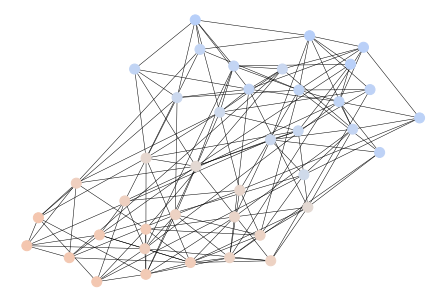

In [148]:
plot_graph(Ga, pos2, node_colors_a, edge_colors_a,
           emin, emax, vmina, vmaxa, node_size=100,
           cmap=plt.cm.coolwarm)
filename0 = f'{path}/graph_teaser_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_org_lam{t_lam0}.png'
plt.savefig(filename0)

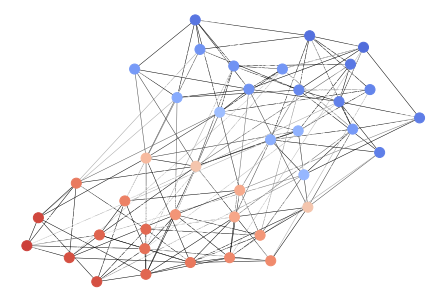

In [149]:
plot_graph(G1, pos2, node_colors_1, edge_colors_1,
           emin, emax, vmin2, vmax2, node_size=100,
           cmap=plt.cm.coolwarm)
filename1 = f'{path}/graph_teaser_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_na_lam{t_lam1}.png'
plt.savefig(filename1)

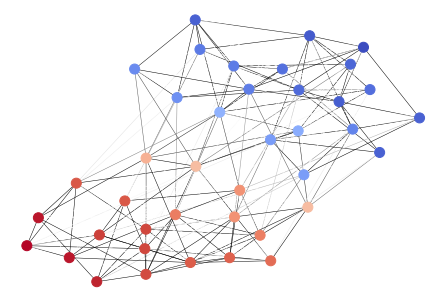

In [150]:
plot_graph(G2, pos2, node_colors_2, edge_colors_2,
           emin, emax, vmin2, vmax2, node_size=100,
           cmap=plt.cm.coolwarm)
filename2 = f'{path}/graph_teaser_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_na_lam{t_lam2}.png'
plt.savefig(filename2)

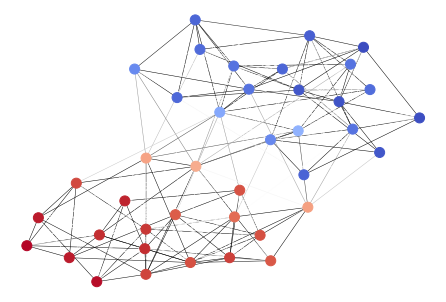

In [142]:
plot_graph(G3, pos2, node_colors_3, edge_colors_3,
           emin, emax, vmin3, vmax3, node_size=100,
           cmap=plt.cm.coolwarm)
filename3 = f'{path}/graph_teaser_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_na_lam{t_lam2}.png'
# plt.savefig(filename3)

# Working with SBM networks (Figure 2, Figure 4)

Below is the code for Figure 2 and Figure 4 in the paper.
For syntethic networks (Stochastic Block Model) we run:

1) Network Administrator Dynamics (Section 3)    
2) Regularized Network Administrator Dynamics (Section 5)


## SBM

In [113]:
import math

n = SBM_N
m = SBM_M
# 1/n ≤ q ≤ p and p > c log4 n/n
c0 = SBM_C
c1 = c0 * n / m
p0 = c0 * math.pow(math.log10(n), 4) / n #0.25
p1 = c1 * math.pow(math.log10(m), 4) / m #0.25
q = max(0.1, min(2 * 1.0 / m, p1 / 2)) #0.1

# create small SBM network
A, s = create_A_s(p0, p1, q, s0_mean=-0.7, s1_mean=0.7, s_std=0.1,
                n=n, m=m, lb=-1.0, ub=1.0)
# A, s = create_A_s(p0, p1, q, s0_mean=0.15, s1_mean=0.85, s_std=0.1,
#                n=n, m=m, lb=0, ub=1)

L = np.diag(np.sum(A, 0)) - A

### Run NA dynamics


In [114]:
# lam: proportion of edges in the original graph you are allowed to change
lam_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# results are dicts of the form
# lambda -> (polarization at each iteration, disagreement at each iter, expressed opinions after NA dynamics, adjacency matrix after NA dynamics)
res_dict={} # results for NA dynamics
res_fix_dict={} # results for regularized NA dynamics

max_iter=7
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A, s, lam,
                            reduce_pls=False, gam=0, max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A, s, lam,
                                reduce_pls=True, gam=gam, max_iters=max_iter)
    
    res_dict[lam] = (pls,disaggs,z,W)
    res_fix_dict[lam] = (pls2,disaggs2,z2,W2)

no fix
lam: 0.1
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 25 rows, 300 columns and 600 nonzeros
Model fingerprint: 0x2001c581
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-08, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
  QRHS range       [7e+01, 7e+01]
Presolve time: 0.03s
Presolved: 327 rows, 302 columns, 979 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.329e+03
 Factor NZ  : 1.788e+03
 Factor Ops : 1.686e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal 

### Save NA dynamics results

In [115]:
_p0 = round(p0, 3)
_p1 = round(p1, 3)
_q = round(q, 3)

fname_sbm = f'{path}/data_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_na.json'
fname_sbm_fix = f'{path}/data_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_l2.json'

save_na_run(res_dict, fname_sbm)
save_na_run(res_fix_dict, fname_sbm_fix)

# rd1 = load_na_run(fname_sbm)
# rd2 = load_na_run(fname_sbm_fix)

# from deepdiff import DeepDiff
# diff2 = DeepDiff(res_dict, rd1)

### Analyze SBM Results

#### Plot polarization, disagreement without regularization

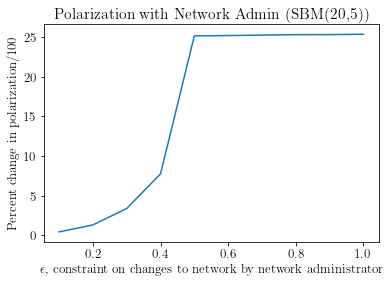

In [116]:
lamvals=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = res_dict[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title(f'Polarization with Network Admin (SBM({n},{m}))')

filename_pol = f'{path}/plot_pol_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_na.png'
plt.savefig(filename_pol)

# large increase in polarization - though not nearly as large as in Reddit :) 

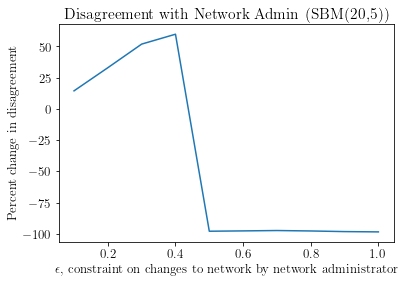

In [117]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = res_dict[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title(f'Disagreement with Network Admin (SBM({n},{m}))')

filename_dis = f'{path}/plot_dis_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_na.png'
plt.savefig(filename_dis)
# wow, disagreement increases a lot too!

#### Plot polarization, disagreement with regularization

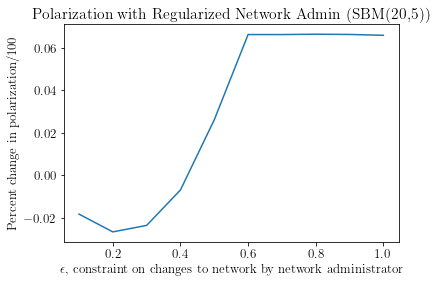

In [118]:
# same plots, but with network fix
lamvals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = res_fix_dict[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title(f'Polarization with Regularized Network Admin (SBM({n},{m}))')
    
filename_pol_fix = f'{path}/plot_pol_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_l2.png'
plt.savefig(filename_pol_fix)

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)

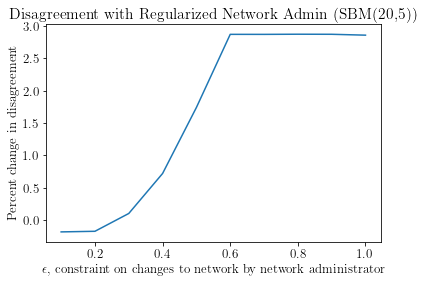

In [119]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = res_fix_dict[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title(f'Disagreement with Regularized Network Admin (SBM({n},{m}))')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

filename_dis_fix = f'{path}/plot_dis_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_l2.png'
plt.savefig(filename_dis_fix)

# okay, so disagreement more-or-less stays the same!

#### Plot graphs of each NA dynamics run

In [120]:
# A, s, L given
z_before=solve(LA+np.eye(n+m),s)
plotlist = []
Ga, posa, edge_colors_a, node_colors_a = vis_params(A, z_before)
plotlist.append(('original', Ga, posa, edge_colors_a, node_colors_a, z_before, 0))

for lam in sorted(res_dict.keys()):
    z1, W1 = res_dict[lam][2], res_dict[lam][3]
    z2, W2 = res_fix_dict[lam][2], res_fix_dict[lam][3]
    G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1)
    G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2)
    plotlist.append(('na', G1, pos1, edge_colors_1, node_colors_1, z1, lam))
    plotlist.append(('l2', G2, pos2, edge_colors_2, node_colors_2, z2, lam))

emin=0.2
emax=1.0

# set scale for vertices
# we want 1.0 to be reddest vertex, 0.0 to be bluest vertex
vmin1=-1.0
# vmin1=0.0
vmax1=1.0

for pl in plotlist:
    pl_lbl, pl_graph, pl_pos, pl_ecol, pl_ncol, pl_z, pl_lam = pl
    vmin2 = np.min(pl_z)
    vmax2 = np.max(pl_z)
    plot_graph(pl_graph, pl_pos, pl_ncol, pl_ecol, emin, emax, vmin1, vmax1,node_size=100)
    filename = f'{path}/graph_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_{pl_lbl}_lam{pl_lam}.png'
    plt.savefig(filename)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

n = SBM_N
m = SBM_M
# 1/n ≤ q ≤ p and p > c log4 n/n
c0 = SBM_C
c1 = c0 * n / m
p0 = c0 * math.pow(math.log10(n), 4) / n #0.25
p1 = c1 * math.pow(math.log10(m), 4) / m #0.25
q = max(0.1, min(2 * 1.0 / m, p1 / 2)) #0.1
_p0 = round(p0, 3)
_p1 = round(p1, 3)
_q = round(q, 3)

dpi_screen = 96
dpi_file = 200
pl_lbl = 'na'
fig = plt.figure(figsize=(w/dpi_screen, h/dpi_screen), dpi=dpi_screen)
lam_list = [ x/10 for x in range(1, 11, 1)]
lam_len = len(lam_list)
rows, cols = 2, 5
w = 432000 / dpi_screen * 5 * 2
h = 288000 / dpi_screen * 2 * 2
for idx, pl_lam in enumerate(lam_list):
    filename = f'{path}/graph_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_{pl_lbl}_lam{pl_lam}.png'
    img = mpimg.imread(filename)

    ax = fig.add_subplot(rows, cols, idx + 1)
    ax.axis('off')

    imgplot = plt.imshow(img)

filename = f'{path}/graph_sbm_n{n}_m{m}_0p{_p0}_1p{_p1}_q{_q}_{pl_lbl}_seq.png'
plt.savefig(filename, dpi=dpi_file)